<a href="https://colab.research.google.com/github/shaja-asm/EMLEC/blob/main/Assessment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ./tmp

import requests, zipfile, io

url = "https://storage.googleapis.com/download.tensorflow.org/data/rps.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall("./tmp")

url = "https://storage.googleapis.com/download.tensorflow.org/data/rps-test-set.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall("./tmp")


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "./tmp/rps/"
VALIDATION_DIR = "./tmp/rps-test-set/"

training_datagen = ImageDataGenerator(
      rescale=1.0/255.0,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=32,
    class_mode='categorical',
    target_size=(150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [34]:
from tensorflow.keras.preprocessing import image

def im_preprocess(img_path, display=False):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((150, 150))

    if display:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


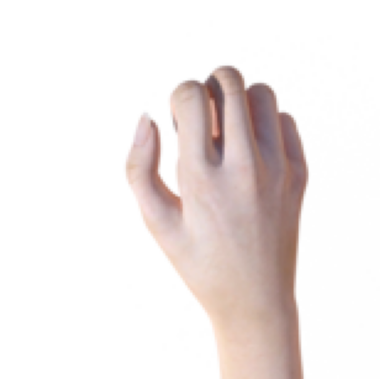

1/1 [==============================] - 0s 89ms/step
[[1.3952343e-05 9.9998462e-01 1.4379015e-06]]

 Prediction before Training: rock


In [53]:
class_names = sorted(os.listdir('./tmp/rps'))

im_path = './tmp/rps/rock/rock01-000.png'
img = im_preprocess(img_path=im_path, display=True)
pred_b4_training = model.predict(img)
print(pred_b4_training)
print('\n Prediction before Training:', class_names[np.argmax(pred_b4_training)])

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [39]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
hist = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback],
    verbose=1
)

Epoch 1/25
79/79 [==============================] - 30s 285ms/step - loss: 1.1091 - accuracy: 0.3484 - val_loss: 1.0193 - val_accuracy: 0.4866
Epoch 2/25
79/79 [==============================] - 23s 295ms/step - loss: 0.9182 - accuracy: 0.5317 - val_loss: 0.4558 - val_accuracy: 0.6801
Epoch 3/25
79/79 [==============================] - 23s 294ms/step - loss: 0.5386 - accuracy: 0.7722 - val_loss: 0.2850 - val_accuracy: 0.9140
Epoch 4/25
79/79 [==============================] - 23s 292ms/step - loss: 0.3484 - accuracy: 0.8631 - val_loss: 0.0419 - val_accuracy: 0.9839
Epoch 5/25
79/79 [==============================] - 22s 283ms/step - loss: 0.2613 - accuracy: 0.8968 - val_loss: 0.1389 - val_accuracy: 0.9543
Epoch 6/25
79/79 [==============================] - 23s 292ms/step - loss: 0.1618 - accuracy: 0.9409 - val_loss: 0.1373 - val_accuracy: 0.9570
Epoch 7/25
79/79 [==============================] - 23s 290ms/step - loss: 0.1526 - accuracy: 0.9433 - val_loss: 0.0711 - val_accuracy: 0.9651

Evaluate on test data
12/12 [==============================] - 1s 117ms/step - loss: 0.0834 - accuracy: 0.9758
test loss, test acc: [0.0834234207868576, 0.975806474685669]


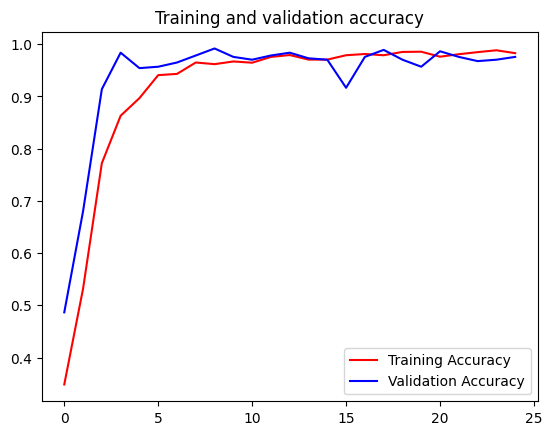

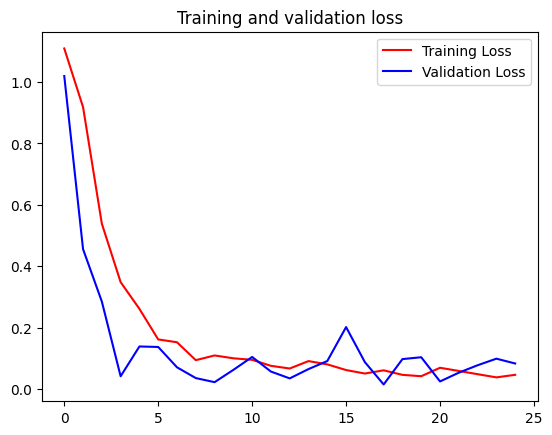

In [43]:
print("Evaluate on test data")
results = model.evaluate(validation_generator)
print("test loss, test acc:", results)

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
model.save("rps_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
trained_model = keras.models.load_model('rps_model.h5')

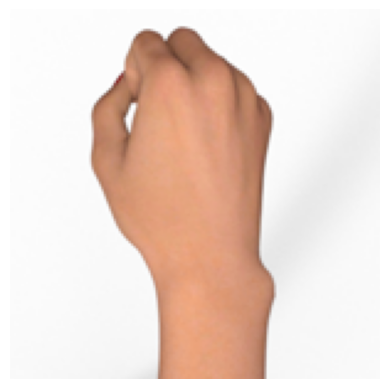

In [47]:
im_path = './tmp/rps-test-set/rock/testrock01-05.png'
img = im_preprocess(img_path=im_path, display=True)

In [48]:
pred_after_training = trained_model.predict(img)
print(pred_after_training)
print('\n Prediction after Training:', class_names[np.argmax(pred_after_training)])

1/1 [==============================] - 0s 132ms/step
[[2.1479260e-05 9.9987304e-01 1.0554098e-04]]

 Prediction after Training: rock


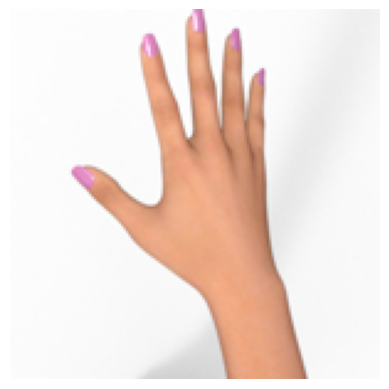

1/1 [==============================] - 0s 22ms/step
[[9.9341416e-01 1.5810838e-05 6.5699872e-03]]

 Prediction after Training: paper


In [49]:
im_path = './tmp/rps-test-set/paper/testpaper01-07.png'
img = im_preprocess(img_path=im_path, display=True)

pred_after_training = trained_model.predict(img)
print(pred_after_training)
print('\n Prediction after Training:', class_names[np.argmax(pred_after_training)])

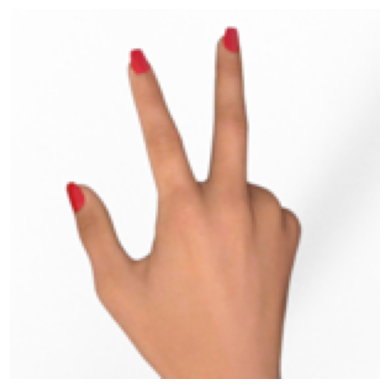

1/1 [==============================] - 0s 21ms/step
[[2.2473250e-04 2.2459238e-04 9.9955064e-01]]

 Prediction after Training: scissors


In [50]:
im_path = './tmp/rps-test-set/scissors/testscissors01-10.png'
img = im_preprocess(img_path=im_path, display=True)

pred_after_training = trained_model.predict(img)
print(pred_after_training)
print('\n Prediction after Training:', class_names[np.argmax(pred_after_training)])